[1/5] Training {'opt': 'adam', 'lr': 0.001, 'opt_kwargs': {}}
[2/5] Training {'opt': 'adam', 'lr': 0.0003, 'opt_kwargs': {}}
[3/5] Training {'opt': 'rmsprop', 'lr': 0.001, 'opt_kwargs': {'rho': 0.9}}
[4/5] Training {'opt': 'adagrad', 'lr': 0.01, 'opt_kwargs': {'init_accum': 0.1}}
[5/5] Training {'opt': 'sgd', 'lr': 0.01, 'opt_kwargs': {'momentum': 0.9, 'nesterov': True}}

=== Best validation accuracy per optimizer config ===
optimizer      lr                                extra  best_val_acc  best_epoch  final_train_acc  epochs_run
     adam  0.0010                                   {}         0.806          23         0.949010          26
     adam  0.0003                                   {}         0.789          30         0.921574          30
  adagrad  0.0100                  {'init_accum': 0.1}         0.761          29         0.858557          30
  rmsprop  0.0010                         {'rho': 0.9}         0.713           2         0.826109           5
      sgd  0.0100  {'

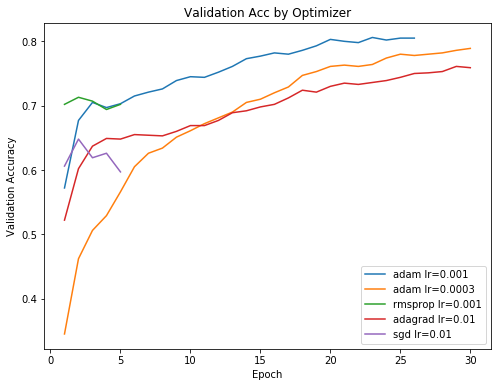

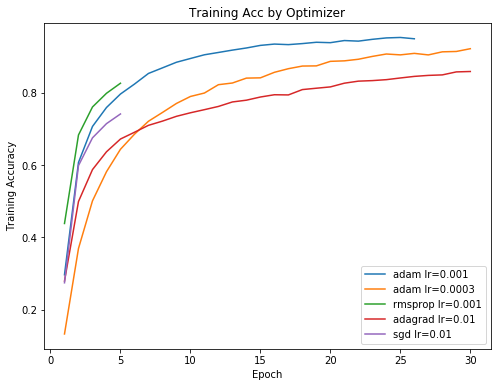


Selected best config: {'optimizer': 'adam', 'lr': 0.001, 'extra': {}, 'best_val_acc': 0.8059999942779541, 'best_epoch': 23, 'final_train_acc': 0.9490102529525757, 'epochs_run': 26}

Test accuracy of best model: 0.8023


In [2]:
# 0) Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from keras import models, layers, regularizers, callbacks, optimizers
from keras.datasets import reuters
from keras.utils import to_categorical

tf.random.set_seed(42); np.random.seed(42)
NUM_WORDS, NUM_CLASSES = 10000, 46
BATCH, MAX_EPOCHS, PATIENCE = 512, 30, 3

# Load & vectorize (7,982 train / 1,000 val / 2,246 test) 
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=NUM_WORDS)

def vectorize(seqs, dim=NUM_WORDS):
    x = np.zeros((len(seqs), dim)); 
    for i, s in enumerate(seqs): x[i, s] = 1.0
    return x

x_train = vectorize(train_data[:7982]);  y_train = to_categorical(train_labels[:7982], NUM_CLASSES)
x_val   = vectorize(train_data[7982:8982]); y_val = to_categorical(train_labels[7982:8982], NUM_CLASSES)
x_test  = vectorize(test_data);          y_test  = to_categorical(test_labels, NUM_CLASSES)

# 2) Model factory (Problem 2’s improved net) 
def build_model(l2=1e-4, drop1=0.5, drop2=0.4, h1=128, h2=64, lr=1e-3, opt_name="adam", opt_kwargs=None):
    if opt_kwargs is None: opt_kwargs = {}
    m = models.Sequential([
        layers.Input((NUM_WORDS,)),
        layers.Dense(h1, activation="relu", kernel_initializer="he_normal",
                     kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Dropout(drop1),
        layers.Dense(h2, activation="relu", kernel_initializer="he_normal",
                     kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Dropout(drop2),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    # choose optimizer
    opt_name = opt_name.lower()
    if opt_name == "adam":
        opt = optimizers.Adam(learning_rate=lr, **opt_kwargs)
    elif opt_name == "adamw":
        opt = optimizers.AdamW(learning_rate=lr, weight_decay=opt_kwargs.get("weight_decay", 1e-4))
    elif opt_name == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=lr, rho=opt_kwargs.get("rho", 0.9))
    elif opt_name == "adagrad":
        opt = optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=opt_kwargs.get("init_accum", 0.1))
    elif opt_name == "sgd":
        opt = optimizers.SGD(learning_rate=lr,
                             momentum=opt_kwargs.get("momentum", 0.9),
                             nesterov=opt_kwargs.get("nesterov", True))
    else:
        raise ValueError("Unknown optimizer")
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return m

# 3) Optimizer search space (≥ 4 optimizers) 
search = [
    {"opt": "adam",    "lr": 1e-3,  "opt_kwargs": {}},
    {"opt": "adam",    "lr": 3e-4,  "opt_kwargs": {}},
    {"opt": "rmsprop", "lr": 1e-3,  "opt_kwargs": {"rho": 0.9}},
    {"opt": "adagrad", "lr": 1e-2,  "opt_kwargs": {"init_accum": 0.1}},
    {"opt": "sgd",     "lr": 1e-2,  "opt_kwargs": {"momentum": 0.9, "nesterov": True}},
]

histories, rows = {}, []

# 4) Train each config with validation; record best val-acc & epoch 
for i, cfg in enumerate(search, start=1):
    print(f"[{i}/{len(search)}] Training {cfg}")
    model = build_model(l2=1e-4, drop1=0.5, drop2=0.4, h1=128, h2=64,
                        lr=cfg["lr"], opt_name=cfg["opt"], opt_kwargs=cfg["opt_kwargs"])
    es  = callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=3e-5, verbose=0)
    hist = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=MAX_EPOCHS, batch_size=BATCH,
                     callbacks=[es, rlr], verbose=0)
    # metrics
    acc = hist.history["accuracy"]; val_acc = hist.history["val_accuracy"]
    best_idx = int(np.argmax(val_acc))
    rows.append({
        "optimizer": cfg["opt"],
        "lr": cfg["lr"],
        "extra": cfg["opt_kwargs"],
        "best_val_acc": float(val_acc[best_idx]),
        "best_epoch": int(best_idx + 1),
        "final_train_acc": float(acc[-1]),
        "epochs_run": int(len(acc))
    })
    histories[(cfg["opt"], cfg["lr"], str(cfg["opt_kwargs"]))] = hist

results_df = pd.DataFrame(rows).sort_values("best_val_acc", ascending=False)
print("\n=== Best validation accuracy per optimizer config ===")
print(results_df.to_string(index=False))

# 5) Plot: training vs validation accuracy for each optimizer 
plt.figure(figsize=(8,6))
for key, hist in histories.items():
    val_acc = hist.history["val_accuracy"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"{key[0]} lr={key[1]}")
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy"); plt.title("Validation Acc by Optimizer")
plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for key, hist in histories.items():
    tr_acc = hist.history["accuracy"]
    plt.plot(range(1, len(tr_acc)+1), tr_acc, label=f"{key[0]} lr={key[1]}")
plt.xlabel("Epoch"); plt.ylabel("Training Accuracy"); plt.title("Training Acc by Optimizer")
plt.legend(); plt.show()

# 6) Pick best config, retrain on ALL 8,982 for its best_epoch, evaluate on 2,246 test 
best = results_df.iloc[0]
print("\nSelected best config:", best.to_dict())

x_full = np.vstack([x_train, x_val]); y_full = np.vstack([y_train, y_val])
best_model = build_model(l2=1e-4, drop1=0.5, drop2=0.4, h1=128, h2=64,
                         lr=float(best["lr"]), opt_name=best["optimizer"],
                         opt_kwargs=best["extra"])
best_model.fit(x_full, y_full, epochs=int(best["best_epoch"]), batch_size=BATCH, verbose=0)
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy of best model: {test_acc:.4f}")


In [3]:
results = []

for i, cfg in enumerate(search, start=1):
    print(f"[{i}/{len(search)}] Training {cfg}")
    model = build_model(l2=1e-4, drop1=0.5, drop2=0.4, h1=128, h2=64,
                        lr=cfg["lr"], opt_name=cfg["opt"], opt_kwargs=cfg["opt_kwargs"])
    es  = callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=3e-5, verbose=0)
    hist = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=MAX_EPOCHS, batch_size=BATCH,
        callbacks=[es, rlr], verbose=0
    )

    # best epoch & val_acc
    val_acc = hist.history["val_accuracy"]
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = np.max(val_acc)

    # Retrain on combined train+val for best_epoch
    x_full = np.vstack([x_train, x_val])
    y_full = np.vstack([y_train, y_val])
    final_model = build_model(l2=1e-4, drop1=0.5, drop2=0.4, h1=128, h2=64,
                              lr=cfg["lr"], opt_name=cfg["opt"], opt_kwargs=cfg["opt_kwargs"])
    final_model.fit(x_full, y_full, epochs=best_epoch, batch_size=BATCH, verbose=0)

    # Evaluate on test set
    test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)

    results.append({
        "optimizer": cfg["opt"],
        "lr": cfg["lr"],
        "extra": cfg["opt_kwargs"],
        "best_epoch": best_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc
    })

# Present as a table
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results.sort_values("test_acc", ascending=False).to_string(index=False))


[1/5] Training {'opt': 'adam', 'lr': 0.001, 'opt_kwargs': {}}
[2/5] Training {'opt': 'adam', 'lr': 0.0003, 'opt_kwargs': {}}
[3/5] Training {'opt': 'rmsprop', 'lr': 0.001, 'opt_kwargs': {'rho': 0.9}}
[4/5] Training {'opt': 'adagrad', 'lr': 0.01, 'opt_kwargs': {'init_accum': 0.1}}
[5/5] Training {'opt': 'sgd', 'lr': 0.01, 'opt_kwargs': {'momentum': 0.9, 'nesterov': True}}
optimizer      lr                                extra  best_epoch  best_val_acc  test_acc
     adam  0.0010                                   {}          28         0.811  0.805877
     adam  0.0003                                   {}          29         0.790  0.786732
  adagrad  0.0100                  {'init_accum': 0.1}          30         0.770  0.770258
  rmsprop  0.0010                         {'rho': 0.9}           5         0.727  0.724844
      sgd  0.0100  {'momentum': 0.9, 'nesterov': True}           1         0.593  0.575690
